In [43]:
import tensorflow as tf 
import math
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore') 

In [44]:
# PART1: Q2 

In [45]:
# I) 
def SV_model_sim_tf_h(iT, phi, sigma_eta, sigma_eps, xi, seed = 123):
    """
    Simulate a univariate stationary stochastic volatility
          y_t = exp(h_t / 2) * eps_t, eps_t is N(0, sigma_eps)
          h_t = phi * h_{t-1} + eta_t, eta_t is N(0, sigma_eta)
    with eps_t and eta_t independent at all leads and lags. 
    
    The case where the innovations are correlated is straightforward to obtain using the closure property of the Gaussian distribution.
    The timing of the correlation coefficient can be either contemporaneous as in Harvey (1996), e.g. rho = E[eta_t*eps_t], or intertemporal
    as in Yu (2005), e.g. rho = E[eta_{t-1}*eps_t]
    
    Input:
    ------
        iT : int, Number of observations.
        phi : float, AR(1) coefficient for the log-volatility. Should be |phi| < 1.
        sigma_eta : float, Standard deviation of eta_t.
        sigma_eps : float, Standard deviation of eps_t.
        xi : float, Scale parameter for the observations.
        seed : int, Random seed for reproducibility.

    Output:
    ------
        dict:
            vY : tf.Tensor, Simulated observations. (iT,)
            h  : tf.Tensor, Latent log-volatility. (iT, )  
    """
    # Check input
    if seed is not None:
        tf.random.set_seed(seed)
    if not isinstance(iT, int) or iT <= 0:
        raise ValueError("iT must be a positive integer")
    if not isinstance(phi, (float, int)) or abs(phi) >= 1:
        raise ValueError("phi must be a scalar in (-1, 1)")
    if not isinstance(sigma_eta, (float, int)) or sigma_eta <= 0:
        raise ValueError("sigma_eta must be positive")
    if not isinstance(sigma_eps, (float, int)) or sigma_eps <= 0:
        raise ValueError("sigma_eps must be positive")
    if not isinstance(xi, (float, int)) or xi <= 0:
        raise ValueError("xi must be positive")

    # Convert input parameters for modelling    
    phi, sigma_eta, sigma_eps, xi = map(lambda x: tf.constant(x, tf.float64), [phi, sigma_eta, sigma_eps, xi])

    # Innovations
    eta = tf.random.normal([iT], mean=0.0, stddev=sigma_eta, dtype=tf.float64)
    eps = tf.random.normal([iT], mean=0.0, stddev=sigma_eps, dtype=tf.float64)

    # h initialised to the stationary distribution of the process, i.e. h0 is N(0, sigma_eta^2 / (1 - phi^2))
    h0_std = sigma_eta / tf.sqrt(1.0 - phi**2)
    h0 = tf.random.normal([], mean=0.0, stddev=h0_std, dtype=tf.float64)

    # Helper function for the time series recursion 
    def helper_transition(h_prev, eta_t):
        return phi * h_prev + eta_t

    h0 = tf.constant(0.0, tf.float64)
    h = tf.scan(helper_transition, eta[1:], initializer=h0)
    h = tf.concat([[h0], h], axis=0)
    # observations
    y = xi*eps * tf.exp(h / 2.0)
    
    return {"vY": y, "h": h}

In [46]:
#II) 
def compute_jacobian_tf(fun, x, tol=1e-6):
    """
    Compute numerical derivative of fun at x using central difference.

    Input:
    ------
    fun : callable, function to differentiate
    x : float or tf.Tensor, point where derivative is evaluated 
    tol : float, small perturbation for finite difference (optional, set to 1e-6)

    Output:
    ------
        J : float or tf.Tensor, numerical derivative of fun at x
    """
    # Check float64
    if isinstance(x, tf.Tensor):
        x = tf.cast(x, dtype=tf.float64)
    else:
        x = tf.convert_to_tensor(x, dtype=tf.float64)

    # Check finiteness
    if not tf.math.is_finite(x):
        raise ValueError("Jacobian: x not finite")
    f1 = tf.convert_to_tensor(fun(x + tol), dtype=tf.float64)
    f2 = tf.convert_to_tensor(fun(x - tol), dtype=tf.float64)
    
    # Check function outputs finite
    if not (tf.math.is_finite(f1) and tf.math.is_finite(f2)):
        raise ValueError("Jacobian: function returned non-finite values")

    # Compute Numerical derivative
    J = (f1 - f2) / (2.0 * tol)

    # Check derivative is finite
    if not tf.math.is_finite(J):
        raise ValueError("Jacobian: non-finite derivative")
        
    # Check derivative is not numerically zero
    if tf.abs(J) < 1e-8:
        raise ValueError(f"Jacobian numerically zero at x = {x.numpy()}")

    return J


def compute_sigma_points_tf(mu, P, alpha=0.5, beta=2.0, kappa=0.0):
    """
    Computes sigma points and corresponding weights for the Unscented Transform
    Operates on a single scalar state; for multivariate states, apply independently per dimension.

    Input:
    ------
    mu : float or tf.Tensor, mean of the state
    P : float or tf.Tensor, variance of the state 
    alpha : float, spread scaling parameter (optional, set to 0.5)
    beta : float, distribution prior info parameter (optional, set to 2.0)
    kappa : float, secondary scaling parameter, (optional, set to 0.0)

    Output:
    ------
    dict: 
        "X" : tf.Tensor, sigma points [mu, mu+spread, mu-spread]  (shape [3])
        "Wm" :  tf.Tensor, weights for mean  (shape [3])
        "Wc" tf.Tensor, weights for covariance (shape [3])
    """
    # Conversion 
    mu = tf.convert_to_tensor(mu, dtype=tf.float64)
    P = tf.convert_to_tensor(P, dtype=tf.float64)
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float64)
    beta = tf.convert_to_tensor(beta, dtype=tf.float64)
    kappa = tf.convert_to_tensor(kappa, dtype=tf.float64)

    # Check input 
    if not tf.math.is_finite(mu):
        raise ValueError("Sigma points: mu not finite")
    if not tf.math.is_finite(P) or P <= 0:
        raise ValueError("Sigma points: P must be positive")

    n = 1
    lambda_ = alpha**2 * (n + kappa) - n
    denom = n + lambda_

    if denom <= 0 or not tf.math.is_finite(denom):
        raise ValueError("Invalid scaling: n + lambda <= 0")

    gamma = tf.sqrt(denom)
    spread = gamma * tf.sqrt(P)

    # Robustness checks
    if not tf.math.is_finite(spread) or spread <= 0:
        raise ValueError("Sigma points collapsed: spread <= 0")
    # 
    if spread < 1e-14 * (tf.abs(mu) + 1):
        raise ValueError("Sigma points numerically degenerate (spread too small)")

    # Compute sigma points: in the univariate case three points are needed 
    X = tf.stack([mu, mu + spread, mu - spread])

    # Check degeneracy 
    tol = 1e-12
    if tf.reduce_max(tf.abs(X - X[0])) < tol:
        raise ValueError("Sigma points degenerate: all points coincide")

    # Compute weights
    Wm = tf.stack([lambda_ / denom, 1.0/(2*denom), 1.0/(2*denom)])
    Wc = tf.identity(Wm)
    Wc = tf.tensor_scatter_nd_add(Wc, [[0]], [1 - alpha**2 + beta])

    # Check weights finite
    if not tf.reduce_all(tf.math.is_finite(Wm)) or not tf.reduce_all(tf.math.is_finite(Wc)):
        raise ValueError("Non-finite UKF weights")

    return {"X": X, "Wm": Wm, "Wc": Wc}
    


def extensionKF_uni_tf_consistent(y, f_fun, h_fun, sigma_eta, sigma_e, m0=0.0, P0=1.0, method="EKF"):
    """
    Function to perform filtering supporting both EKF and UKF algorithms 
    Performs recursive prediction and update for a sequence of scalar observations.
    Consistent with compute_jacobian_tf and compute_sigma_points_tf.

    Input:
    ------
    y: array-like, Observations, shape = (T, )
    f_fun: callable, State transition function f(x) for x_{t} = f(x_{t-1}) + transition_noise.
    h_fun: callable, Observation function h(x) for y_t = h(x_t) + measurement_noise.
    sigma_eta: float, Standard deviation of the transition noise.
    sigma_e: float, Standard deviation of the measurement noise.
    m0: float, Initial state mean (set to 0.0)
    P0: float, Initial state variance (set to 1.0)
    method: str, optional
        Filtering method: "EKF" (Extended Kalman Filter) or "UKF" (Unscented Kalman Filter).
    
    Output
    -------
    dict:
        "mu_filt": filtered means
        "P_filt": filtered variances
        "mu_pred": predicted means
        "P_pred": predicted variances
        "llk": approximated log-likelihood 
    """
    # ---------- Method check ----------
    method = method.upper()
    if method not in ("EKF", "UKF"):
        raise ValueError("method must be 'EKF' or 'UKF'")

    # ---------- Convert inputs ----------
    y = tf.convert_to_tensor(y, dtype=tf.float64)
    m0 = tf.convert_to_tensor(m0, dtype=tf.float64)
    P0 = tf.convert_to_tensor(P0, dtype=tf.float64)
    sigma_eta = tf.convert_to_tensor(sigma_eta, dtype=tf.float64)
    sigma_e = tf.convert_to_tensor(sigma_e, dtype=tf.float64)

    # Check input 
    if y.shape.ndims != 1 or tf.size(y) < 2: #or y.shape[0] is None: 
        raise ValueError("y must be a 1D vector of length >= 2") ## 2 <= length < T = inf 
    if not tf.reduce_all(tf.math.is_finite(y)):
        raise ValueError("the values of y must be finite")
    # Parameters: finiteness and 1D
    for val, name in [(m0, "m0"), (P0, "P0"), # (y, "y"), 
                      (sigma_eta, "sigma_eta"), (sigma_e, "sigma_e")]:
        if not tf.reduce_all(tf.math.is_finite(val)):
            raise ValueError(f"{name} must be finite")
        if val.shape.ndims != 0:
            raise ValueError(f"{name} must be a scalar (0-dimensional tensor)")

    if P0 <= 0 or sigma_eta <= 0 or sigma_e <= 0:
        raise ValueError("P0, sigma_eta, and sigma_e must be positive")

    if not callable(f_fun):
        raise ValueError("f_fun must be a function")
    if not callable(h_fun):
        raise ValueError("h_fun must be a function")

    n = tf.shape(y)[0]  # number of observations
    pi_tf = tf.constant(math.pi, dtype=tf.float64)

    # Allocation space 
    mu_pred = tf.Variable(tf.zeros(n, dtype=tf.float64))
    mu_filt = tf.Variable(tf.zeros(n, dtype=tf.float64))
    P_pred  = tf.Variable(tf.zeros(n, dtype=tf.float64))
    P_filt  = tf.Variable(tf.zeros(n, dtype=tf.float64))
    v       = tf.Variable(tf.zeros(n, dtype=tf.float64))
    llk     = tf.Variable(0.0, dtype=tf.float64)

    mu_filt[0].assign(m0)
    P_filt[0].assign(P0)
    mu_pred[0].assign(m0)
    P_pred[0].assign(P0)
    v[0].assign(tf.constant(0.0, dtype=tf.float64))

    # Recursion
    t_indices = tf.range(1, n, dtype=tf.int32)

    for t in t_indices:
        ### Prediction
        if method == "EKF":
            Jf = compute_jacobian_tf(f_fun, mu_filt[t-1])
            mu_pred_t = f_fun(mu_filt[t-1])
            P_pred_t = Jf**2 * P_filt[t-1] + sigma_eta**2
        else:  # UKF
            sp = compute_sigma_points_tf(mu_filt[t-1], P_filt[t-1])
            X, Wm, Wc = sp["X"], sp["Wm"], sp["Wc"]
            X_pred = tf.stack([f_fun(xi) for xi in X])
            if not tf.reduce_all(tf.math.is_finite(X_pred)):
                raise ValueError(f"Non-finite prediction at t={t}")
            mu_pred_t = tf.reduce_sum(Wm * X_pred)
            P_pred_t = sigma_eta**2 + tf.reduce_sum(Wc * (X_pred - mu_pred_t)**2)
            
        # Check P_pred
        if not tf.math.is_finite(P_pred_t) or P_pred_t <= 0:
            raise ValueError(f"Invalid P_pred at t={t}")

        mu_pred[t].assign(mu_pred_t)
        P_pred[t].assign(P_pred_t)

        # Update
        if method == "EKF":
            Jh = compute_jacobian_tf(h_fun, mu_pred_t)
            v_t = y[t] - h_fun(mu_pred_t)
            S_t = Jh**2 * P_pred_t + sigma_e**2
            if not tf.math.is_finite(S_t) or S_t <= 0:
                raise ValueError(f"Invalid S_t at t={t}")
            K = P_pred_t * Jh / S_t
            mu_t_filt = mu_pred_t + K * v_t
            P_t_filt = (1 - K * Jh) * P_pred_t
        else:  # UKF
            sp = compute_sigma_points_tf(mu_pred_t, P_pred_t)
            X, Wm, Wc = sp["X"], sp["Wm"], sp["Wc"]
            Y = tf.stack([h_fun(xi) for xi in X])
            if not tf.reduce_all(tf.math.is_finite(Y)):
                raise ValueError(f"Non-finite observation mapping at t={t}")
            mu_y = tf.reduce_sum(Wm * Y)
            if tf.reduce_all(tf.abs(Y - mu_y) < 1e-12):
                raise ValueError(f"Observation sigma points collapsed at t={t}")
            S_t = sigma_e**2 + tf.reduce_sum(Wc * (Y - mu_y)**2)
            if not tf.math.is_finite(S_t) or S_t <= 0:
                raise ValueError(f"Invalid S_t at t={t}")
            C_xy = tf.reduce_sum(Wc * (X - mu_pred_t) * (Y - mu_y))
            if tf.abs(C_xy) < 1e-14 * (tf.abs(mu_pred_t) + 1):
                raise ValueError(f"UKF degeneracy detected: C_xy ≈ 0 at t={t}")
            K = C_xy / S_t
            v_t = y[t] - mu_y
            mu_t_filt = mu_pred_t + K * v_t
            P_t_filt = P_pred_t - K**2 * S_t
        # State checks
        if not tf.math.is_finite(mu_t_filt) or not tf.math.is_finite(P_t_filt) or P_t_filt <= 0:
            raise ValueError(f"Invalid filtered state at t={t}")
        mu_filt[t].assign(mu_t_filt)
        P_filt[t].assign(P_t_filt)
        v[t].assign(v_t)
        # Lielihood via prediction error decomposition 
        llk_inc = -0.5 * (tf.math.log(2.0 * pi_tf * S_t) + v_t**2 / S_t)
        if not tf.math.is_finite(llk_inc):
            raise ValueError(f"Invalid log-likelihood increment at t={t}")
        llk.assign_add(llk_inc)

    return {
        "mu_filt": mu_filt,
        "P_filt": P_filt,
        "mu_pred": mu_pred,
        "P_pred": P_pred,
        "llk": llk
    }

In [16]:
### EXAMPLES for the results then just put the functions elsewhere

In [17]:
## Monte Carlo experiment - NONLNEAR CASE should degenerate
# Parameters
T = 200
phi = 0.7
sigma_eta = 0.2
sigma_e = 0.1

tf.random.set_seed(42) # for reproducibility

# Initial state x[0] ~ N(0,1)
x0 = tf.random.normal([], mean=0.0, stddev=1.0, dtype=tf.float64)
x = tf.TensorArray(tf.float64, size=T)
x = x.write(0, x0)

# State recursion
for t in range(1, T):
    eta_t = tf.random.normal([], mean=0.0, stddev=sigma_eta, dtype=tf.float64)
    x_t = phi * x.read(t-1) + eta_t
    x = x.write(t, x_t)
x = x.stack()

# Observations
y = x**2 / 5 + tf.random.normal([T], mean=0.0, stddev=sigma_e, dtype=tf.float64)


# Define f() and h() for the nonlinear model
def f_fun_tf(x):
    return phi * x

def h_fun_tf(x):
    return x**2 / 5

In [18]:
# APPLICATION with a nonlinear model
# EKF 
res_EKF_tf = extensionKF_uni_tf_consistent(
    y=y,
    f_fun=f_fun_tf,
    h_fun=h_fun_tf,
    sigma_eta=sigma_eta,
    sigma_e=sigma_e,
    m0=tf.constant(0.5, dtype=tf.float64),
    P0=tf.constant(1.0, dtype=tf.float64),
    method="EKF"  
)

ValueError: Jacobian numerically zero at x = 1.9678049065769916e-08

In [19]:
res_UKF_tf = extensionKF_uni_tf_consistent(
    y=y,
    f_fun=f_fun_tf,
    h_fun=h_fun_tf,
    sigma_eta=sigma_eta,
    sigma_e=sigma_e,
    m0=tf.constant(0.5, dtype=tf.float64),
    P0=tf.constant(1.0, dtype=tf.float64),
    method="UKF"  
)

ValueError: UKF degeneracy detected: C_xy ≈ 0 at t=63

In [ ]:
## see below for the SV application

In [47]:
# III) 
def SIR_bootstrap_markov_tf_stat(Y, N, phi, tau, sigma, squared=False):
    """
    SIR bootstrap particle filter. 
    Particles initialised to the stationary distribution of the process.
    Exploiting the Markovian property: it only keeps the latest particles
    
    Input
    ------
    Y: array-like, Observations. Shape (T, )
    N: int, Number of particles.
    phi: float, AR(1) coefficient for latent variable. Must be |phi|<1
    tau: float, Std of the transition noise.
    sigma: float, Std of observation noise.
    squared: bool
        If True, estimate second moment of the state variable.
        Otherwise, estimate the mean of the state variable
    
    Output
    -------
    dict
        'part_est' : array-like, estimated expectation (or second moment if squared = True) (T,)
        'ESS' : array-like, effective sample size (T,)
        'loglikelihood' : scalar, approximate log-likelihood 
    """
    # Check input
    if N <= 0:
        raise ValueError("N must be positive")
    if not (-1 < phi < 1):
        raise ValueError("phi must be in (-1,1)")
    if tau <= 0 or sigma <= 0:
        raise ValueError("tau and sigma must be positive")
    if Y is None or len(Y) < 2:
        raise ValueError("Y must have at least 2 observations")
    if not isinstance(squared, bool):
        raise ValueError("squared must be a boolean")

    # Convert to float64 ---
    Y = tf.convert_to_tensor(Y, dtype=tf.float64)
    # Check Y is univariate 
    if Y.shape.ndims != 1:
        raise ValueError("Y must be a univariate time series")
    phi = tf.convert_to_tensor(phi, dtype=tf.float64)
    tau = tf.convert_to_tensor(tau, dtype=tf.float64)
    sigma = tf.convert_to_tensor(sigma, dtype=tf.float64)

    T = tf.shape(Y)[0]

    # Allocation space
    part_est = tf.Variable(tf.zeros(T, dtype=tf.float64))
    ESS = tf.Variable(tf.zeros(T, dtype=tf.float64))
    loglik = tf.constant(0.0, dtype=tf.float64)
    
    # Initialisation  
    # Sample particles from stationary distribution
    h0_std = tau / tf.sqrt(1.0 - phi**2)
    h0_std = tf.cast(h0_std, dtype=tf.float64)  
    X = tf.random.normal((N,), mean=tf.constant(0.0, dtype=tf.float64),
                         stddev=h0_std, dtype=tf.float64)
    # weights
    log_w_raw = -0.5 * ((Y[0] - X)/sigma)**2 - tf.math.log(sigma) - 0.5*tf.math.log(tf.constant(2*math.pi, dtype=tf.float64))
    log_w = log_w_raw - tf.reduce_logsumexp(log_w_raw)
    w = tf.exp(log_w)

    ESS[0].assign(1.0 / tf.reduce_sum(w**2))
    loglik += tf.reduce_logsumexp(log_w_raw) - tf.math.log(tf.cast(N, tf.float64))
    part_est[0].assign(tf.reduce_mean(X if not squared else X**2))

    # Recursion
    for t in tf.range(1, T):
        # State
        X = phi * X + tf.random.normal((N,), dtype=tf.float64) * tau
        # Log-weights - robust computation using LogSumExp
        log_w_raw = -0.5 * ((Y[t] - X)/sigma)**2 - tf.math.log(sigma) - 0.5*tf.math.log(tf.constant(2*math.pi, dtype=tf.float64))
        log_w = log_w_raw - tf.reduce_logsumexp(log_w_raw)
        w = tf.exp(log_w)
        # ESS and log-likelihood
        ESS[t].assign(1.0 / tf.reduce_sum(w**2))
        loglik += tf.reduce_logsumexp(log_w_raw) - tf.math.log(tf.cast(N, tf.float64))
        # Systematic resampling
        cdf = tf.cumsum(w)
        u0 = tf.random.uniform((), dtype=tf.float64) / tf.cast(N, tf.float64)
        u = u0 + tf.range(N, dtype=tf.float64) / tf.cast(N, tf.float64)
        idx = tf.searchsorted(cdf, u)
        X = tf.gather(X, idx)

        # Particle estimate
        part_est[t].assign(tf.reduce_mean(X if not squared else X**2))

    return {
        "part_est": part_est,
        "ESS": ESS,
        "loglikelihood": loglik
    }

In [39]:
### Simulate from the model SV above 
# Fixed parameters
phi = 0.95
sigma_eta = 0.2
xi = 1.0
sigma_eps = 1.0

# generate data
sim_sv_tf_out = SV_model_sim_tf_h(iT=500, phi=phi, sigma_eta=sigma_eta, xi=xi, sigma_eps=sigma_eps)
y_tf = sim_sv_tf_out["vY"]
h_tf = sim_sv_tf_out["h"]

In [22]:
# add results for ESS
#check 
SIR_markov_v1 = SIR_bootstrap_markov_tf_stat(N = 50, phi = phi, tau = sigma_eta, sigma = sigma_eps, squared=False, Y=y_tf)
SIR_markov_v2 = SIR_bootstrap_markov_tf_stat(N = 150, phi = phi, tau = sigma_eta, sigma = sigma_eps, squared=False, Y=y_tf)
SIR_markov_v3 = SIR_bootstrap_markov_tf_stat(N = 500, phi = phi, tau = sigma_eta, sigma = sigma_eps, squared=False, Y=y_tf)

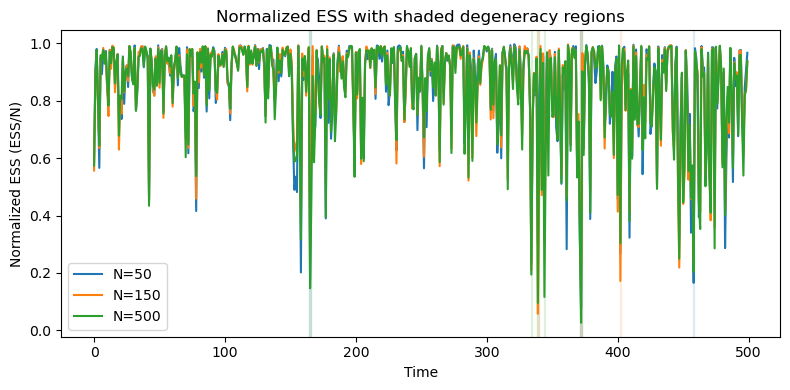

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Example ESS arrays from your SIR runs
ESS_50  = np.array(SIR_markov_v1_stat_1["ESS"])
ESS_150 = np.array(SIR_markov_v1_stat_2["ESS"])
ESS_500 = np.array(SIR_markov_v1_stat_3["ESS"])

# Normalize ESS by number of particles
ESS_50_norm  = ESS_50 / 50
ESS_150_norm = ESS_150 / 150
ESS_500_norm = ESS_500 / 500

# Define threshold for severe degeneracy (e.g., less than 0.2 of particles effective)
degeneracy_threshold = 0.2

plt.figure(figsize=(8,4))

# Plot normalized ESS
plt.plot(ESS_50_norm,  label="N=50")
plt.plot(ESS_150_norm, label="N=150")
plt.plot(ESS_500_norm, label="N=500")

# Shaded regions where ESS/N < threshold
for i, ESS_norm in enumerate([ESS_50_norm, ESS_150_norm, ESS_500_norm]):
    degenerate_indices = np.where(ESS_norm < degeneracy_threshold)[0]
    for idx in degenerate_indices:
        plt.axvspan(idx-0.5, idx+0.5, color=f"C{i}", alpha=0.1)

#plt.axhline(degeneracy_threshold, color="red", linestyle="--", label="Severe degeneracy threshold")
plt.xlabel("Time")
plt.ylabel("Normalized ESS (ESS/N)")
plt.title("Normalized ESS with shaded degeneracy regions")
plt.legend()
plt.tight_layout()
plt.savefig("normalized_ESS.png", dpi=300)
plt.show()


In [48]:
# IV) 
def compute_bias_rmse(x_true, x_est):
    """
    Compute Bias and RMSE between the true and estimated values of two arrays.
    Input:
    ------
        x_true: array-like of shape [T] or [T, d], any numeric type
        x_est: array-like of shape [T] or [T, d], any numeric type
        
    Output:
    ------
        bias: scalar tensor
        rmse: scalar tensor
    """
    # Convert to tensors if needed
    if not isinstance(x_est, tf.Tensor):
        x_est = tf.convert_to_tensor(x_est, dtype=tf.float64)
    if not isinstance(x_true, tf.Tensor):
        x_true = tf.convert_to_tensor(x_true, dtype=x_est.dtype)
        
    # Check data type and shapes
    if x_true.dtype != x_est.dtype:
        x_true = tf.cast(x_true, dtype=x_est.dtype)
    x_true = tf.reshape(x_true, tf.shape(x_est))
    
    # Compute bias and RMSE
    bias = tf.reduce_mean(x_est - x_true)
    rmse = tf.sqrt(tf.reduce_mean(tf.square(x_true - x_est)))
    
    return bias, rmse


def profile_tf(func, *args, warmup=True, **kwargs):
    # Warmup 
    if warmup:
        func(*args, **kwargs)
    # Reset GPU memory stats
    gpu_available = len(tf.config.list_physical_devices("GPU")) > 0
    if gpu_available:
        try:
            tf.config.experimental.reset_memory_stats("GPU:0")
        except:
            pass
            
    # Tracking time 
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()

    # GPU memory 
    gpu_stats = None
    if gpu_available:
        try:
            mem = tf.config.experimental.get_memory_info("GPU:0")
            gpu_stats = {
                "current_MB": mem["current"] / 1024**2,
                "peak_MB": mem["peak"] / 1024**2,
            }
        except:
            pass

    return result, {
        "runtime_seconds": end - start,
        "gpu_memory": gpu_stats
    }

In [27]:
### APPLICATION

### BPF vs. EKF/UKF in the SV model

y = y_tf
z = tf.math.log(y**2 + 1e-8)  # approximate additive Gaussian model based on Harvey
z = tf.convert_to_tensor(z, dtype=tf.float64)

xi_tf = tf.constant(xi, dtype=tf.float64)
sigma_eps_tf = tf.constant(sigma_eps, dtype=tf.float64)
c0 = tf.math.log(xi_tf**2 * sigma_eps_tf**2) - tf.constant(1.2704, dtype=tf.float64) # see Harvey (1996)

# Define functions to compute the Taylor approx.
def f_fun_sv(x):
    return phi * x

def h_fun_sv(x):
    return x + c0 # see Harvey (1996)

In [ ]:
# Apply EKF
res_EKF_sv = extensionKF_uni_tf_consistent(
y=z, f_fun=f_fun_sv, h_fun=h_fun_sv, sigma_eta=sigma_eta, sigma_e=sigma_eps_tf, m0=tf.constant(0.0, dtype=tf.float64), 
    P0=tf.constant(1.0, dtype=tf.float64), method="EKF")

# Apply UKF
res_UKF_sv = extensionKF_uni_tf_consistent(
y=z, f_fun=f_fun_sv, h_fun=h_fun_sv, sigma_eta=sigma_eta, sigma_e=sigma_eps_tf, m0=tf.constant(0.0, dtype=tf.float64), P0=tf.constant(1.0, dtype=tf.float64),
method="UKF")


In [38]:
# SIR_markov_v1_stat_1
print(compute_bias_rmse(h_tf, SIR_markov_v1_stat_1['part_est']))
print(compute_bias_rmse(h_tf, SIR_markov_v1_stat_2['part_est']))
print(compute_bias_rmse(h_tf, SIR_markov_v1_stat_3['part_est']))

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.2085361275987812>, <tf.Tensor: shape=(), dtype=float64, numpy=0.6739978420591409>)
(<tf.Tensor: shape=(), dtype=float64, numpy=-0.217681122629444>, <tf.Tensor: shape=(), dtype=float64, numpy=0.6754382207075584>)
(<tf.Tensor: shape=(), dtype=float64, numpy=-0.22177678549198038>, <tf.Tensor: shape=(), dtype=float64, numpy=0.6798767361705239>)


In [42]:
print(compute_bias_rmse(h_tf, res_EKF_sv['mu_filt']))
compute_bias_rmse(h_tf, res_UKF_sv['mu_filt'])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.007205532730531167>, <tf.Tensor: shape=(), dtype=float64, numpy=0.6013056217170069>)


(<tf.Tensor: shape=(), dtype=float64, numpy=-0.007205532731196857>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.601305621729205>)

In [31]:
result_perf, stats_perf = profile_tf(
    SIR_bootstrap_markov_tf_stat,
    N=50,
    phi=phi,
    tau=sigma_eta,
    sigma=sigma_eps,
    squared=False,
    Y=y_tf
)

In [34]:
result_perf_100, stats_perf_100 = profile_tf(
    SIR_bootstrap_markov_tf_stat,
    N=100,
    phi=phi,
    tau=sigma_eta,
    sigma=sigma_eps,
    squared=False,
    Y=y_tf
)
result_perf_500, stats_perf_500 = profile_tf(
    SIR_bootstrap_markov_tf_stat,
    N=500,
    phi=phi,
    tau=sigma_eta,
    sigma=sigma_eps,
    squared=False,
    Y=y_tf
)
result_perf_1000, stats_perf_1000 = profile_tf(
    SIR_bootstrap_markov_tf_stat,
    N=1000,
    phi=phi,
    tau=sigma_eta,
    sigma=sigma_eps,
    squared=False,
    Y=y_tf
)

In [32]:
result_perf_ukf, stats_perf_ukf = profile_tf(extensionKF_uni_tf_consistent, y=z, f_fun=f_fun_sv, h_fun=h_fun_sv, sigma_eta=sigma_eta, sigma_e=sigma_eps_tf, m0=tf.constant(0.0, dtype=tf.float64),
    P0=tf.constant(1.0, dtype=tf.float64), method="UKF")

In [33]:
result_perf_ekf, stats_perf_ekf = profile_tf(extensionKF_uni_tf_consistent, y=z, f_fun=f_fun_sv, h_fun=h_fun_sv, sigma_eta=sigma_eta, sigma_e=sigma_eps_tf, m0=tf.constant(0.0, dtype=tf.float64),
    P0=tf.constant(1.0, dtype=tf.float64), method="EKF")

In [35]:
print("Runtime SIR (N = 50):", stats_perf["runtime_seconds"], "seconds")
print("GPU peak memory SIR:", stats_perf["gpu_memory"], "MB")
#
print("Runtime SIR (N = 100):", stats_perf_100["runtime_seconds"], "seconds")
print("GPU peak memory SIR:", stats_perf_100["gpu_memory"], "MB")
print("Runtime SIR (N = 500):", stats_perf_500["runtime_seconds"], "seconds")
print("GPU peak memory SIR:", stats_perf_500["gpu_memory"], "MB")
print("Runtime SIR (N = 1000):", stats_perf_1000["runtime_seconds"], "seconds")
print("GPU peak memory SIR:", stats_perf_1000["gpu_memory"], "MB")
print("Runtime EKF:", stats_perf_ukf["runtime_seconds"], "seconds")
print("GPU peak memory UKF:", stats_perf_ukf["gpu_memory"], "MB")
#
print("Runtime UKF:", stats_perf_ekf["runtime_seconds"], "seconds")
print("GPU peak memory UKF:", stats_perf_ekf["gpu_memory"], "MB")

Runtime SIR (N = 50): 4.546427699999185 seconds
GPU peak memory SIR: None MB
Runtime SIR (N = 100): 4.782228299998678 seconds
GPU peak memory SIR: None MB
Runtime SIR (N = 500): 4.871139499999117 seconds
GPU peak memory SIR: None MB
Runtime SIR (N = 1000): 5.4311302000132855 seconds
GPU peak memory SIR: None MB
Runtime EKF: 10.56537890000618 seconds
GPU peak memory UKF: None MB
Runtime UKF: 5.480352000013227 seconds
GPU peak memory UKF: None MB


In [ ]:
### TESTS

In [49]:
import unittest
import tensorflow as tf

class TestSVModelSimTF(tf.test.TestCase):
    # ---------------------------
    # Output structure & non-degeneracy
    # ---------------------------
    def test_structure_and_non_degenerate_output(self):
        """Check that outputs have correct types, shapes, and are non-degenerate."""
        params_list = [
            dict(iT=10, phi=0.95, sigma_eta=0.2, sigma_eps=1.0, xi=1.0),
            dict(iT=15, phi=0.8, sigma_eta=0.1, sigma_eps=0.5, xi=2.0),
            dict(iT=5, phi=0.5, sigma_eta=0.3, sigma_eps=1.5, xi=0.5)
        ]

        for params in params_list:
            out = SV_model_sim_tf_h(**params)
            # Check dictionary
            self.assertIsInstance(out, dict)
            self.assertSetEqual(set(out.keys()), {"vY", "h"})
            # vY and h
            for key in ["vY", "h"]:
                val = out[key]
                self.assertIsInstance(val, tf.Tensor)
                self.assertEqual(val.dtype, tf.float64)
                self.assertEqual(val.shape[0], params["iT"])
                # non-degenerate: finite and not constant
                values = val.numpy()
                self.assertTrue(np.all(np.isfinite(values)), msg=f"{key} contains non-finite values")
                self.assertFalse(np.all(values == values[0]), msg=f"{key} degenerate: all values equal to {values[0]}")
    # ---------------------------
    # Sanity check
    # ---------------------------
    def test_valid_configs(self):
        """Run the simulation on valid configurations"""
        configs = [
            dict(iT=50, phi=0.95, sigma_eta=0.2, sigma_eps=1.0, xi=1.0),
            dict(iT=100, phi=0.8, sigma_eta=0.1, sigma_eps=0.5, xi=2.0),
            dict(iT=200, phi=0.5, sigma_eta=0.3, sigma_eps=1.5, xi=0.7)
        ]
        for cfg in configs:
            out = SV_model_sim_tf_h(**cfg)
            for key in ["vY", "h"]:
                values = out[key].numpy()
                self.assertTrue(np.all(np.isfinite(values)))
                self.assertFalse(np.all(values == values[0]), msg=f"{key} degenerate output")
    # ---------------------------
    # Check invalid input
    # ---------------------------
    def test_invalid_inputs_raise(self):
        """Check that invalid numeric inputs raise errors."""
        bad_calls = [
            dict(iT=-10, phi=0.95, sigma_eta=0.2, sigma_eps=1.0, xi=1.0),
            dict(iT=500, phi=1.2, sigma_eta=0.2, sigma_eps=1.0, xi=1.0),
            dict(iT=500, phi=-2.1, sigma_eta=0.2, sigma_eps=1.0, xi=1.0),
            dict(iT=500, phi=0.95, sigma_eta=-0.2, sigma_eps=1.0, xi=1.0),
            dict(iT=500, phi=0.95, sigma_eta=0.2, sigma_eps=-1.0, xi=1.0),
            dict(iT=0, phi=0.95, sigma_eta=0.2, sigma_eps=1.0, xi=1.0),
        ]
        for kwargs in bad_calls:
            with self.assertRaises(ValueError):
                SV_model_sim_tf_h(**kwargs)

#if __name__ == "__main__":
#    tf.test.main()
#    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [50]:
import unittest
import tensorflow as tf

class TestJacobian(tf.test.TestCase):

    def test_scalar_output_and_dtype(self):
        f = lambda x: x**2
        x = tf.constant(2.0)
        J = compute_jacobian_tf(f, x)

        self.assertIsInstance(J, tf.Tensor)
        self.assertEqual(J.shape, ())
        self.assertEqual(J.dtype, tf.float64)

    def test_correct_value(self):
        f = lambda x: x**3
        x = tf.constant(2.0)
        J = compute_jacobian_tf(f, x)

        # Analytical derivative = 3x^2 = 12
        self.assertAllClose(J.numpy(), 12.0, atol=1e-4)

    def test_non_finite_input_raises(self):
        f = lambda x: x**2
        x = tf.constant(float('nan'))

        with self.assertRaises(ValueError):
            compute_jacobian_tf(f, x)

    def test_zero_derivative_raises(self):
        f = lambda x: tf.constant(1.0, dtype=tf.float64)
        x = tf.constant(2.0)

        with self.assertRaises(ValueError):
            compute_jacobian_tf(f, x)

#if __name__ == "__main__":
#    tf.test.main()
#    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [51]:
class TestSigmaPointsTF(tf.test.TestCase):

    def test_weighted_mean_recovers_mu(self):
        """Check that the weighted mean of sigma points equals the input mean."""
        mu = 0.0
        P = 1.0
        sp = compute_sigma_points_tf(mu, P)
        X, Wm = sp["X"], sp["Wm"]

        mu_rec = tf.reduce_sum(Wm * X)
        self.assertAllClose(mu_rec, mu, atol=1e-10)

    def test_output_structure_and_types(self):
        """Check dictionary keys, tensor types, and dtypes."""
        sp = compute_sigma_points_tf(mu=0.0, P=1.0)
        self.assertIsInstance(sp, dict)
        self.assertSetEqual(set(sp.keys()), {"X", "Wm", "Wc"})

        X, Wm, Wc = sp["X"], sp["Wm"], sp["Wc"]
        self.assertIsInstance(X, tf.Tensor)
        self.assertIsInstance(Wm, tf.Tensor)
        self.assertIsInstance(Wc, tf.Tensor)

        self.assertEqual(X.dtype, tf.float64)
        self.assertEqual(Wm.dtype, tf.float64)
        self.assertEqual(Wc.dtype, tf.float64)

    def test_output_shapes(self):
        """Check output shapes (assuming univariate sigma points, n=1)."""
        sp = compute_sigma_points_tf(mu=0.0, P=1.0)
        X, Wm, Wc = sp["X"], sp["Wm"], sp["Wc"]

        self.assertEqual(X.shape, (3,))
        self.assertEqual(Wm.shape, (3,))
        self.assertEqual(Wc.shape, (3,))

    def test_all_outputs_finite(self):
        """Ensure all outputs are finite."""
        mu = 1.5
        P = 2.0
        sp = compute_sigma_points_tf(mu, P)
        X, Wm, Wc = sp["X"], sp["Wm"], sp["Wc"]

        # Check all elements are finite using tf.reduce_all
        self.assertTrue(tf.reduce_all(tf.math.is_finite(X)).numpy())
        self.assertTrue(tf.reduce_all(tf.math.is_finite(Wm)).numpy())
        self.assertTrue(tf.reduce_all(tf.math.is_finite(Wc)).numpy())

    def test_sigma_spread_positive(self):
        """Ensure sigma points spread and are not collapsing"""
        mu = tf.constant(1.0, dtype=tf.float64)
        P = tf.constant(2.0, dtype=tf.float64)
        sp = compute_sigma_points_tf(mu, P)
        X = sp["X"]

        spread_plus = X[1] - mu
        spread_minus = mu - X[2]

        self.assertGreater(spread_plus, 0, "Sigma points did not spread above mu")
        self.assertGreater(spread_minus, 0, "Sigma points did not spread below mu")
        self.assertAllClose(spread_plus, spread_minus, atol=1e-12, msg="Sigma points not symmetric")

    def test_weights_sum_and_symmetry(self):
        """Mean weights sum to 1 and off-center weights are symmetric"""
        sp = compute_sigma_points_tf(mu=0.0, P=1.0)
        Wm, Wc = sp["Wm"], sp["Wc"]

        self.assertAllClose(tf.reduce_sum(Wm), 1.0, atol=1e-12)
        self.assertAllClose(Wm[1], Wm[2], atol=1e-12)
        self.assertAllClose(Wc[1], Wc[2], atol=1e-12)

    def test_covariance_reconstruction(self):
        mu = tf.constant(0.5, dtype=tf.float64)
        P = tf.constant(1.5, dtype=tf.float64)
        sp = compute_sigma_points_tf(mu, P)
        X = tf.convert_to_tensor(sp["X"], dtype=tf.float64)
        Wc = tf.convert_to_tensor(sp["Wc"], dtype=tf.float64)
        reconstructed_P = tf.reduce_sum(Wc * (X - mu)**2)

    def test_small_P_degeneracy(self):
        """Very small P should raise a ValueError due to numerical collapse"""
        with self.assertRaises(ValueError):
            compute_sigma_points_tf(mu=1.0, P=1e-30)

    def test_invalid_P_raises(self):
        """Negative covariance should raise ValueError."""
        with self.assertRaises(ValueError):
            compute_sigma_points_tf(mu=0.0, P=-1.0)

    def test_nonfinite_mu_raises(self):
        """Non-finite mean should raise ValueError."""
        with self.assertRaises(ValueError):
            compute_sigma_points_tf(mu=tf.constant(np.nan, dtype=tf.float64), P=1.0)


#if __name__ == "__main__":
#    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [52]:
import tensorflow as tf
class TestExtensionKFUniTF(tf.test.TestCase):
    # ---------------------------
    # Output structure and non-degeneracy
    # ---------------------------
    def test_structure_and_non_degenerate_states(self):
        """Check keys, shapes, dtypes, and non-degenerate states for EKF/UKF."""
        y = tf.constant([0.0, 0.2, 0.5, 1.0], dtype=tf.float64)
        # functions
        systems = [
            # linear
            (lambda x: 0.5*x + 0.1, lambda x: 2.0*x + 0.5),
            # non-linear
            (lambda x: 0.1 + 0.5*x + 0.2*tf.sin(x),
             lambda x: 0.5 + 0.5*x + 0.1*tf.cos(x))
        ]
        sigma_eta = sigma_e = tf.constant(0.1, dtype=tf.float64)
        m0 = tf.constant(0.0, dtype=tf.float64)
        P0 = tf.constant(1.0, dtype=tf.float64)

        for f_fun, h_fun in systems:
            for method in ["EKF", "UKF"]:
                out = extensionKF_uni_tf_consistent(
                    y, f_fun, h_fun, sigma_eta, sigma_e, m0, P0, method=method
                )
                # che ck output type
                self.assertIsInstance(out, dict)
                self.assertSetEqual(set(out.keys()), {"mu_filt", "P_filt", "mu_pred", "P_pred", "llk"})
                # variables
                for key in ["mu_filt", "P_filt", "mu_pred", "P_pred"]:
                    self.assertIsInstance(out[key], tf.Variable)
                    self.assertEqual(out[key].dtype, tf.float64)
                    self.assertEqual(out[key].shape, y.shape)
                    # non-degeneracy: finite and non-constant equal values
                    self.assertTrue(tf.reduce_all(tf.math.is_finite(out[key])).numpy())
                    values = out[key].numpy()
                    self.assertFalse(np.all(values == values[0]),
                                    msg=f"{key} degenerate: constant values equal to {values[0]}")
                    #if "P" in key:
                    #    self.assertTrue(tf.reduce_all(out[key] > 0).numpy())
                # likelihood
                self.assertIsInstance(out["llk"], tf.Variable)
                self.assertEqual(out["llk"].dtype, tf.float64)
                self.assertEqual(out["llk"].shape, ())
    # ---------------------------
    # Error raising
    # ---------------------------
    def test_invalid_method_error(self):
        y = [0.0, 1.0]
        f_fun = h_fun = lambda x: x
        sigma_eta = sigma_e = 0.1
        with self.assertRaises(ValueError):
            extensionKF_uni_tf_consistent(y, f_fun, h_fun, sigma_eta, sigma_e, method="m")
            
    def test_multivariate_input_error(self):
        """Check that passing multivariate time-series observations raises ValueError."""
        y_multi = tf.constant([[0.0, 0.1], [0.2, 0.3]], dtype=tf.float64)
        f_fun = lambda x: x
        h_fun = lambda x: x
        sigma_eta = sigma_e = tf.constant(0.1, dtype=tf.float64)
        m0 = tf.constant(0.0, dtype=tf.float64)
        P0 = tf.constant(1.0, dtype=tf.float64)
        
        for method in ["EKF", "UKF"]:
            with self.assertRaises(ValueError):
                extensionKF_uni_tf_consistent(y_multi, f_fun, h_fun, sigma_eta, sigma_e, m0, P0, method=method)                
                
    def test_ukf_degeneracy_error(self):
        """UKF degeneracy gives ValueError"""
        y = tf.constant([0.0, 0.0], dtype=tf.float64)
        # strong non-linearity
        f_fun = lambda x: tf.tanh(x) * 1e-12
        h_fun = lambda x: tf.tanh(x) * 1e-12
        sigma_eta = sigma_e = tf.constant(0.1, dtype=tf.float64)
        with self.assertRaises(ValueError):
            extensionKF_uni_tf_consistent(y, f_fun, h_fun, sigma_eta, sigma_e, method="UKF")
            
    def test_ekf_jacobian_zero_error(self):
        """A zero Jacobian yields EKF degeneracy and a ValueError"""
        y = tf.constant([0.0, 0.0], dtype=tf.float64)
        f_fun = lambda x: tf.sin(x)
        h_fun = lambda x: x**3  # derivative equal to x=0
        sigma_eta = sigma_e = tf.constant(0.1, dtype=tf.float64)
        with self.assertRaises(ValueError):
            extensionKF_uni_tf_consistent(y, f_fun, h_fun, sigma_eta, sigma_e, method="EKF")
            
#if __name__ == "__main__":
#    import unittest
## in the notebook we need to prevent the notebook kernel from shutting down:
#    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [53]:
class TestSIRBootstrapTF(tf.test.TestCase):
    # ---------------------------
    # Output structure & non-degeneracy
    # ---------------------------
    def test_structure_and_non_degenerate_output(self):
        """Check output keys, types, dtypes, shapes, and non-degenerate particle estimates."""
        Y = tf.constant([0.0, 0.1, 0.3, 0.6], dtype=tf.float64)
        configs = [
            {"N": 50, "phi": 0.5, "tau": 0.2, "sigma": 0.3, "squared": False},
            {"N": 100, "phi": 0.9, "tau": 0.1, "sigma": 0.2, "squared": True},
        ]

        for cfg in configs:
            out = SIR_bootstrap_markov_tf_stat(Y=Y, **cfg)
            # Check dictionary
            self.assertIsInstance(out, dict)
            self.assertSetEqual(set(out.keys()), {"part_est", "ESS", "loglikelihood"})
            # part_est and ESS
            for key in ["part_est", "ESS"]:
                self.assertIsInstance(out[key], tf.Variable)
                self.assertEqual(out[key].dtype, tf.float64)
                self.assertEqual(out[key].shape, Y.shape)

                vals = out[key].numpy()
                self.assertTrue(np.all(np.isfinite(vals)), msg=f"{key} contains non-finite values")
                self.assertFalse(np.all(vals == vals[0]),
                                 msg=f"{key} degenerate: all values equal to {vals[0]}")
            # loglikelihood
            self.assertIsInstance(out["loglikelihood"], tf.Tensor)
            self.assertEqual(out["loglikelihood"].dtype, tf.float64)
            self.assertEqual(out["loglikelihood"].shape, ())
    # ---------------------------
    # Check option squared 
    # ---------------------------
    def test_squared_mode_runs(self):
        """Check that squared=True runs correctly and produces finite, non-negative output."""
        Y = tf.constant([0.2, 0.0, -0.1, 0.4], dtype=tf.float64)
        out = SIR_bootstrap_markov_tf_stat(
            N=150,
            phi=0.8,
            tau=0.3,
            sigma=0.2,
            squared=True,
            Y=Y
        )
        vals = out["part_est"].numpy()
        self.assertTrue(np.all(np.isfinite(vals)))
        self.assertTrue(np.all(vals >= 0), msg="Squared estimates should be non-negative")
    # ---------------------------
    # Sanity check: correct behaviour
    # ---------------------------
    def test_sanity_multi(self):
        """Runs without error on different reasonable configurations."""
        Y = tf.constant([0.0, 0.2, 0.4, 0.1, -0.2], dtype=tf.float64)
        configs = [
            dict(N=100, phi=0.7, tau=0.2, sigma=0.3),
            dict(N=200, phi=0.95, tau=0.1, sigma=0.5, squared=True),
            dict(N=50, phi=0.5, tau=0.4, sigma=0.2),
        ]
        for cfg in configs:
            out = SIR_bootstrap_markov_tf_stat(Y=Y, **cfg)
            vals = out["part_est"].numpy()
            self.assertTrue(np.all(np.isfinite(vals)))
            self.assertFalse(np.all(vals == vals[0]), msg="Degenerate output")
    # ---------------------------
    # Error raising tests
    # ---------------------------
    def test_invalid_inputs_raise(self):
        """Function raises ValueError on invalid inputs."""
        Y = tf.constant([0.0, 0.1], dtype=tf.float64)
        bad_calls = [
            # N <= 0
            dict(N=0, phi=0.9, tau=0.2, sigma=0.3, Y=Y),
            # phi outside (-1, 1)
            dict(N=100, phi=-2.1, tau=0.2, sigma=0.3, Y=Y),
            dict(N=100, phi=1.2,  tau=0.2, sigma=0.3, Y=Y),
            # tau or sigma <= 0
            dict(N=100, phi=0.9, tau=-0.1, sigma=0.3, Y=Y),
            dict(N=100, phi=0.9, tau=0.2,  sigma=0.0, Y=Y),
            # Y invalid
            dict(N=100, phi=0.9, tau=0.2, sigma=0.3, Y=[1.0]),
            dict(N=100, phi=0.9, tau=0.2, sigma=0.3, Y=None),
        ]
    
        for kwargs in bad_calls:
            with self.assertRaises(ValueError):
                SIR_bootstrap_markov_tf_stat(**kwargs)
    # ---------------------------
    # Invalid squared argument
    # ---------------------------
    def test_invalid_squared_raises(self):
        Y = tf.constant([0.0, 0.1, 0.2], dtype=tf.float64)
        with self.assertRaises(ValueError):
            SIR_bootstrap_markov_tf_stat(N=100, phi=0.5, tau=0.2, sigma=0.3, squared="yes", Y=Y)
        with self.assertRaises(ValueError):
            SIR_bootstrap_markov_tf_stat(N=100, phi=0.5, tau=0.2, sigma=0.3, squared=None, Y=Y)

    def test_multivariate_Y_raises(self):
        """ Raising Error if Y is not 1D."""
        Y = tf.constant([[0.1, 0.2], [0.3, 0.4]], dtype=tf.float64)

        with self.assertRaises(Exception):
            SIR_bootstrap_markov_tf_stat(
                N=100, phi=0.9, tau=0.2, sigma=0.3, Y=Y
            )

#if __name__ == "__main__":
#    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [54]:
class TestComputeBiasRMSE(tf.test.TestCase):
    def test_output_structure(self):
        """Check bias and RMSE for 1D and 2D arrays are scalar tensors and finite"""
        test_cases = [
            # 1D arrays
            (tf.constant([1.0, 2.0, 3.0], dtype=tf.float64),
            tf.constant([1.1, 1.9, 3.2], dtype=tf.float64)),
            # 2D arrays
            (np.array([[1.0, 2.0], [3.0, 4.0]]),
            np.array([[1.1, 1.9], [2.8, 4.2]]))
        ]
        for x_true, x_est in test_cases:
            bias, rmse = compute_bias_rmse(x_true, x_est)
            # Check output type and shape
            self.assertIsInstance(bias, tf.Tensor)
            self.assertIsInstance(rmse, tf.Tensor)
            self.assertEqual(bias.shape, ())
            self.assertEqual(rmse.shape, ())
            # Check values are finite
            self.assertTrue(tf.reduce_all(tf.math.is_finite(bias)).numpy())
            self.assertTrue(tf.reduce_all(tf.math.is_finite(rmse)).numpy())
            self.assertGreaterEqual(rmse.numpy(), 0.0)

    def test_type(self):
        """Ensure function handles different data types."""
        x_true = np.array([1, 2, 3], dtype=np.float32)
        x_est = tf.constant([0.9, 2.1, 3.0], dtype=tf.float64)

        bias, rmse = compute_bias_rmse(x_true, x_est)
        self.assertEqual(bias.dtype, tf.float64)
        self.assertEqual(rmse.dtype, tf.float64)
        self.assertTrue(np.all(np.isfinite(bias.numpy())))
        self.assertTrue(np.all(np.isfinite(rmse.numpy())))

#if __name__ == "__main__":
#    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [55]:
import unittest
# Create a loader and suite
loader = unittest.TestLoader()
suite = unittest.TestSuite()
# Loop over globals to find all tf.test.TestCase subclasses
for name, obj in globals().items():
    if isinstance(obj, type) and issubclass(obj, tf.test.TestCase):
        suite.addTests(loader.loadTestsFromTestCase(obj))
# Run all tests
unittest.TextTestRunner(verbosity=1).run(suite)

RuntimeError: dictionary changed size during iteration

In [57]:
import unittest
import io
test_output = io.StringIO()

# Run all tests in the current module (__main__) and redirect output
runner = unittest.TextTestRunner(stream=test_output, verbosity=2)
loader = unittest.TestLoader()
suite = loader.loadTestsFromModule(__import__('__main__'))

runner.run(suite)

# Print results in notebook
print(test_output.getvalue())

# Save results to a file in the notebook folder
with open("test_results_q1b.txt", "w") as f:
    f.write(test_output.getvalue())


INFO:tensorflow:time(__main__.TestComputeBiasRMSE.test_output_structure): 0.01s
INFO:tensorflow:time(__main__.TestComputeBiasRMSE.test_type): 0.0s
INFO:tensorflow:time(__main__.TestExtensionKFUniTF.test_ekf_jacobian_zero_error): 0.04s
INFO:tensorflow:time(__main__.TestExtensionKFUniTF.test_invalid_method_error): 0.0s
INFO:tensorflow:time(__main__.TestExtensionKFUniTF.test_multivariate_input_error): 0.0s
INFO:tensorflow:time(__main__.TestExtensionKFUniTF.test_structure_and_non_degenerate_states): 0.23s
INFO:tensorflow:time(__main__.TestExtensionKFUniTF.test_ukf_degeneracy_error): 0.05s
INFO:tensorflow:time(__main__.TestJacobian.test_correct_value): 0.01s
INFO:tensorflow:time(__main__.TestJacobian.test_non_finite_input_raises): 0.0s
INFO:tensorflow:time(__main__.TestJacobian.test_scalar_output_and_dtype): 0.0s
INFO:tensorflow:time(__main__.TestJacobian.test_zero_derivative_raises): 0.0s
INFO:tensorflow:time(__main__.TestSIRBootstrapTF.test_invalid_inputs_raise): 0.0s
INFO:tensorflow:time

In [1]:
!pip3 install unittest-xml-reporting

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os, time, unittest, xmlrunner
os.makedirs("test_results_q2", exist_ok=True)
timestamp = time.strftime("%Y%m%d-%H%M%S")

with open(f"test_results_q2/sigma_points_{timestamp}.xml", "wb") as output:
    unittest.main(
        argv=["ignored"],        # Ignore Jupyter args
        testRunner=xmlrunner.XMLTestRunner(output=output),
        exit=False
    )



Running tests...
----------------------------------------------------------------------

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

Generating XML reports...
